# Model Training 
This is the code is the training code for ML-based approach in intrusion detection. It was modified from notebook provided by "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)".

Please also cite:
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder 

In [3]:
CHECKPOINT_OUTPUT = "./models_ps"

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [4]:
# Read the dataset
df = pd.read_csv('../../datasets/output/train_final_2.csv', parse_dates=['Timestamp'])

In [5]:
df = df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Old Index', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time', 'ICMP Type', 'ICMP Code'], axis=1)

In [6]:
df['Label'].value_counts()

Label
Benign       486349
Portscan     127232
Slowloris      3063
Name: count, dtype: int64

In [7]:
df['Label'] = df['Label'].map({
    "Slowloris": "Not Portscan",
    "Portscan": "Portscan",
    "Benign": "Not Portscan"
})

In [8]:
df['Label'].value_counts()

Label
Not Portscan    489412
Portscan        127232
Name: count, dtype: int64

### Data pre-processing

In [9]:
# Encode the dataset
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [10]:
df['Label'].value_counts()

Label
0    489412
1    127232
Name: count, dtype: int64

In [11]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Portscan', 'Portscan'])

array([0, 1])

In [12]:
df.isnull().any().any()

False

In [13]:
df.isna().any().any()

False

In [14]:
X = df.drop(['Label'],axis=1) 
y = df['Label'].values.reshape(-1,1)
y=np.ravel(y)

In [15]:
labelencoder.classes_

array(['Not Portscan', 'Portscan'], dtype='<U12')

## Cross Validation Preparation

In [16]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

splits = []
for train_index, test_index in skf.split(X, y):
    splits.append((train_index, test_index))

In [17]:
i = 0
for train_index, test_index in splits:
    pd.Series(train_index).to_csv(f"{CHECKPOINT_OUTPUT}/imbalance_train_idx_{i}.csv", index=False)
    pd.Series(test_index).to_csv(f"{CHECKPOINT_OUTPUT}/imbalance_test_idx_{i}.csv", index=False)
    i += 1

## Data Balancing by Proposed TVAE-based Method

In [18]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer

def balance_data_with_tvae(df, X_train, y_train):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)

    y_train = pd.Series(y_train)

    # Identify the average number of samples per class
    average_samples = y_train.value_counts().mean()

    # Identify minority classes with less than half the average number of samples
    minority_classes = y_train.value_counts()
    minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

    # Prepare an empty DataFrame to collect synthetic data
    synthetic_data = pd.DataFrame()

    y_train.index = X_train.index

    # Generating synthetic samples for each minority class using TVAE
    for cls in minority_classes:
        cls_samples = X_train[y_train == cls]
        num_samples_needed = int(average_samples - len(cls_samples))
        
        # Initialize the TVAE model with detected metadata
        tvaegan = TVAESynthesizer(metadata=metadata, cuda=True, verbose=True)
        
        # Fit the TVAE model on the minority class samples
        tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
        
        # Generate synthetic instances to match the average class sample size
        new_samples = tvaegan.sample(num_samples_needed)
        
        # Append the new synthetic instances to the synthetic data list
        synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)
    
    # Concatenate the original and synthetic data to form a balanced dataset
    balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

    # Display the new distribution of labels in the balanced dataset
    print(balanced_data['Label'].value_counts())

    # Prepare the balanced dataset for model training
    return (balanced_data.drop(['Label'], axis=1), balanced_data['Label'])

In [19]:
X_train_full_balanced, y_train_full_balanced = balance_data_with_tvae(df, X, y)
X_train_full_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/X_train_full_balanced.pkl")
y_train_full_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/y_train_full_balanced.pkl")

Loss: -601.252: 100%|██████████| 300/300 [35:37<00:00,  7.13s/it]


Label
0    489412
1    308322
Name: count, dtype: int64


In [20]:
balanced_splits = []
i = 0
for train_idx, _ in splits:
    X_train_balanced, y_train_balanced = balance_data_with_tvae(df, X.iloc[train_idx], y[train_idx])
    X_train_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/X_train_balanced_{i}.pkl")
    y_train_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/y_train_balanced_{i}.pkl")
    balanced_splits.append((X_train_balanced, y_train_balanced))
    i += 1

Loss: -595.609: 100%|██████████| 300/300 [23:28<00:00,  4.69s/it]


Label
0    326274
1    205548
Name: count, dtype: int64


Loss: -600.329: 100%|██████████| 300/300 [23:31<00:00,  4.70s/it]


Label
0    326275
1    205548
Name: count, dtype: int64


Loss: -557.017: 100%|██████████| 300/300 [23:49<00:00,  4.77s/it]


Label
0    326275
1    205548
Name: count, dtype: int64


In [21]:
for train_index, test_index in splits:
    print(pd.Series(y[train_index]).value_counts(dropna=False))
    print(pd.Series(y[test_index]).value_counts(dropna=False))

0    326274
1     84822
Name: count, dtype: int64
0    163138
1     42410
Name: count, dtype: int64
0    326275
1     84821
Name: count, dtype: int64
0    163137
1     42411
Name: count, dtype: int64
0    326275
1     84821
Name: count, dtype: int64
0    163137
1     42411
Name: count, dtype: int64


In [22]:
for i in range(3):
    test_idx = splits[i][1]
    X.iloc[test_idx].to_pickle(f"{CHECKPOINT_OUTPUT}/X_validation_{i}.pkl")
    pd.Series(y[test_idx]).to_pickle(f"{CHECKPOINT_OUTPUT}/y_validation_{i}.pkl")

## Checkpoint

In [4]:
X_train_full_balanced = pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_train_full_balanced.pkl")
y_train_full_balanced = pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_train_full_balanced.pkl")

In [5]:
balanced_train_splits = []
for i in range(3):
    balanced_train_splits.append((pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_train_balanced_{i}.pkl"), pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_train_balanced_{i}.pkl")))

In [6]:
val_splits = []
for i in range(3):
    val_splits.append((pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_validation_{i}.pkl"), pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_validation_{i}.pkl")))

## Machine learning model training (for feature selection)

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


In [7]:
import joblib
MODEL_OUTPUT_PREFS = "./models_ps/prefs"

In [8]:
from sklearn.metrics import f1_score

def cross_val_f1_binary(clf):
    results = []
    for i in range(3):
        X_train_balanced, y_train_balanced = balanced_train_splits[i]
        X_val, y_val = val_splits[i]
        clf.fit(X_train_balanced, y_train_balanced)
        y_pred = clf.predict(X_val)
        results.append(f1_score(y_val, y_pred, average='binary'))
    return results

#### DT

In [9]:
import time
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_f1_binary(dt)

start = time.time()
dt.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

Training time:  8.41348123550415
Cross-Validation scores:  [0.9999646314002428, 0.9999056826220231, 0.9999528435348486]
Mean of Cross-Validation scores:  0.9999410525190382


In [10]:
joblib.dump(dt, f"{MODEL_OUTPUT_PREFS}/dt.pkl")

['./models_ps/prefs/dt.pkl']

#### RF

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_jobs=12)
rf_scores = cross_val_f1_binary(rf)

start = time.time()
rf.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

Training time:  17.066004514694214
Cross-Validation scores:  [0.9999764212114781, 0.9999410509437744, 0.9999764217674243]
Mean of Cross-Validation scores:  0.999964631307559


In [12]:
joblib.dump(rf, f"{MODEL_OUTPUT_PREFS}/rf.pkl")

['./models_ps/prefs/rf.pkl']

#### ET

In [13]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=12)
et_scores = cross_val_f1_binary(et)

# calculate the training time
start = time.time()
et.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

Training time:  14.44329833984375
Cross-Validation scores:  [0.9999882101887548, 0.9999646314002428, 1.0]
Mean of Cross-Validation scores:  0.9999842805296658


In [14]:
joblib.dump(et, f"{MODEL_OUTPUT_PREFS}/et.pkl")

['./models_ps/prefs/et.pkl']

#### XGBoost

In [15]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=12)
xg_scores = cross_val_f1_binary(xg)

# calculate the training time
start = time.time()
xg.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

Training time:  2.165937662124634
Cross-Validation scores:  [0.9999528435348486, 0.9999292619665173, 0.9999764217674243]
Mean of Cross-Validation scores:  0.99995284242293


In [16]:
joblib.dump(xg, f"{MODEL_OUTPUT_PREFS}/xg.pkl")

['./models_ps/prefs/xg.pkl']

#### LightGBM

In [17]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_f1_binary(lgbm)

# calculate the training time
start = time.time()
lgbm.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16242
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

In [18]:
joblib.dump(lgbm, f"{MODEL_OUTPUT_PREFS}/lgbm.pkl")

['./models_ps/prefs/lgbm.pkl']

#### Catboost

In [19]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False, cat_features=['Protocol'], thread_count=12)
cat_scores = cross_val_f1_binary(cat)

# calculate the training time
start = time.time()
cat.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

Training time:  43.40453767776489
Cross-Validation scores:  [0.9999764212114781, 0.9999292619665173, 0.9999646330680814]
Mean of Cross-Validation scores:  0.9999567720820256


In [20]:
joblib.dump(cat, f"{MODEL_OUTPUT_PREFS}/cat.pkl")

['./models_ps/prefs/cat.pkl']

In [21]:
import gc
gc.collect()

20

## Model selection

In [22]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)
}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [23]:
base_model_performance

{'dt': 0.9999410525190382,
 'rf': 0.999964631307559,
 'et': 0.9999842805296658,
 'xg': 0.99995284242293,
 'lgbm': 0.9999371247130945,
 'cat': 0.9999567720820256}

In [24]:
ranked_models

['et', 'rf', 'cat', 'xg', 'dt', 'lgbm']

In [25]:
top_3_models

['et', 'rf', 'cat']

## Automated Feature Selection

In [26]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [27]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [28]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature = X_train_full_balanced.columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.2148, 'Bwd RST Flags'), (0.0742, 'Flow Duration'), (0.0693, 'RST Flag Count'), (0.0563, 'Fwd Segment Size Avg'), (0.0355, 'Packet Length Mean'), (0.0348, 'Protocol'), (0.034, 'Fwd Seg Size Min'), (0.0332, 'Average Packet Size'), (0.0319, 'Total Length of Fwd Packet'), (0.0299, 'Flow IAT Max'), (0.0277, 'Flow Bytes/s'), (0.0275, 'Bwd Packets/s'), (0.0238, 'Fwd Packet Length Max'), (0.0233, 'Down/Up Ratio'), (0.0214, 'Packet Length Max'), (0.0213, 'Fwd Header Length'), (0.0158, 'Bwd Segment Size Avg'), (0.0155, 'Bwd Packet Length Max'), (0.015, 'FWD Init Win Bytes'), (0.0148, 'Fwd Packet Length Mean'), (0.0147, 'Bwd Packet Length Mean'), (0.0134, 'Fwd Act Data Pkts'), (0.0116, 'Bwd Packet Length Std'), (0.0115, 'Total Length of Bwd Packet'), (0.0115, 'Bwd Act Data Pkts'), (0.0098, 'Packet Length Std'), (0.0093, 'Bwd Init Win Bytes'), (0.0093, 'Active Mean'), (0.0079, 'Flow IAT Mean'), (0.0073, 'Fwd IAT Total'), (0.006, 'SYN Flag Count'), (0.0057, 'Fwd 

In [29]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break

In [30]:
print(fs)

['Bwd RST Flags', 'Flow Duration', 'RST Flag Count', 'Fwd Segment Size Avg', 'Packet Length Mean', 'Protocol', 'Fwd Seg Size Min', 'Average Packet Size', 'Total Length of Fwd Packet', 'Flow IAT Max', 'Flow Bytes/s', 'Bwd Packets/s', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Packet Length Max', 'Fwd Header Length', 'Bwd Segment Size Avg', 'Bwd Packet Length Max', 'FWD Init Win Bytes', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Fwd Act Data Pkts', 'Bwd Packet Length Std', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Packet Length Std', 'Bwd Init Win Bytes']


In [7]:
fs = ['Bwd RST Flags', 'Flow Duration', 'RST Flag Count', 'Fwd Segment Size Avg', 'Packet Length Mean', 'Protocol', 'Fwd Seg Size Min', 'Average Packet Size', 'Total Length of Fwd Packet', 'Flow IAT Max', 'Flow Bytes/s', 'Bwd Packets/s', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Packet Length Max', 'Fwd Header Length', 'Bwd Segment Size Avg', 'Bwd Packet Length Max', 'FWD Init Win Bytes', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Fwd Act Data Pkts', 'Bwd Packet Length Std', 'Total Length of Bwd Packet', 'Bwd Act Data Pkts', 'Packet Length Std', 'Bwd Init Win Bytes']

In [31]:
pairs = [(0.2148, 'Bwd RST Flags'), (0.0742, 'Flow Duration'), (0.0693, 'RST Flag Count'), (0.0563, 'Fwd Segment Size Avg'), (0.0355, 'Packet Length Mean'), (0.0348, 'Protocol'), (0.034, 'Fwd Seg Size Min'), (0.0332, 'Average Packet Size'), (0.0319, 'Total Length of Fwd Packet'), (0.0299, 'Flow IAT Max'), (0.0277, 'Flow Bytes/s'), (0.0275, 'Bwd Packets/s'), (0.0238, 'Fwd Packet Length Max'), (0.0233, 'Down/Up Ratio'), (0.0214, 'Packet Length Max'), (0.0213, 'Fwd Header Length'), (0.0158, 'Bwd Segment Size Avg'), (0.0155, 'Bwd Packet Length Max'), (0.015, 'FWD Init Win Bytes'), (0.0148, 'Fwd Packet Length Mean'), (0.0147, 'Bwd Packet Length Mean'), (0.0134, 'Fwd Act Data Pkts'), (0.0116, 'Bwd Packet Length Std'), (0.0115, 'Total Length of Bwd Packet'), (0.0115, 'Bwd Act Data Pkts'), (0.0098, 'Packet Length Std'), (0.0093, 'Bwd Init Win Bytes')]

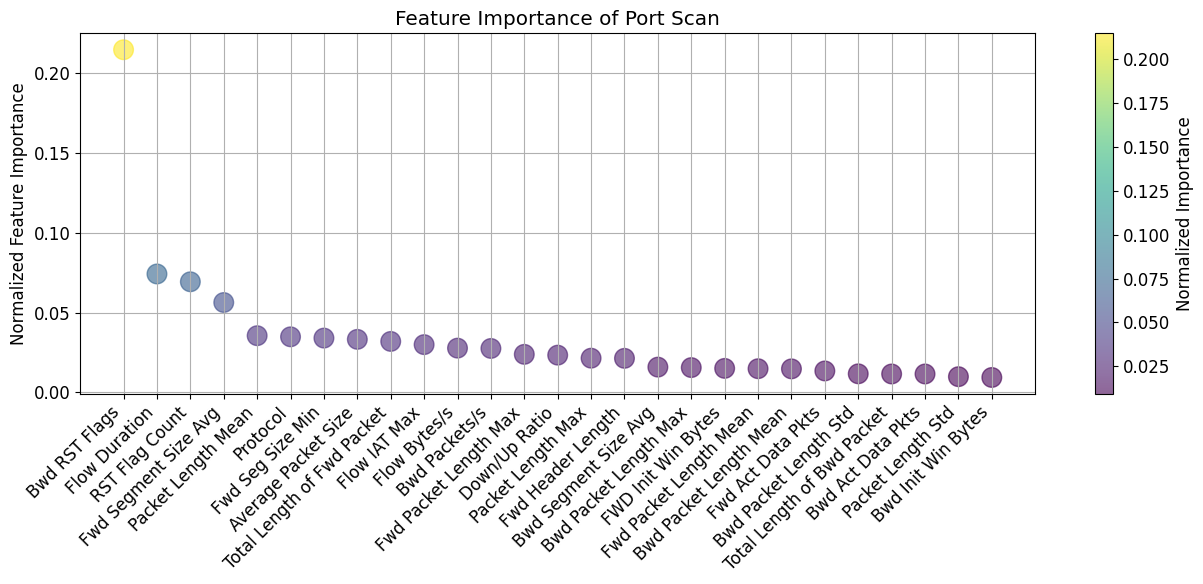

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

features = pd.DataFrame(pairs, columns=['Importance', 'Feature'])

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(13, 6))
scatter = plt.scatter(
    x=features['Feature'],
    y=features['Importance'],
    s=200,
    c=features['Importance'],
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance of Port Scan')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
num_features_original = len(X_train_full_balanced.columns)
num_features_selected = len(fs)

print(f"Features before selection: {num_features_original}")
print(f"Features after selection: {num_features_selected}")

Features before selection: 81
Features after selection: 27


In [8]:
X_train_full_balanced_fs = X_train_full_balanced[fs]

In [9]:
balanced_train_splits_fs = []
val_splits_fs = []
for i in range(3):
    X_train_balanced, y_train_balanced = balanced_train_splits[i]
    X_val, y_val = val_splits[i]
    balanced_train_splits_fs.append((X_train_balanced[fs], y_train_balanced))
    val_splits_fs.append((X_val[fs], y_val))

# Testing

## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

In [10]:
POST_FS_MODEL_OUTPUT = "./models_ps/postfs"

In [ ]:
def cross_val_f1_binary_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]
        clf.fit(X_train_balanced_fs, y_train_balanced_fs)
        y_pred_fs = clf.predict(X_val_fs)
        results.append(f1_score(y_val_fs, y_pred_fs, average='binary'))
    return results

### DT

In [42]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_f1_binary_fs(dt)

start = time.time()
dt.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

Training time:  4.142423868179321
Cross-Validation scores:  [0.9999646314002428, 0.9998938967025452, 0.9999528435348486]
Mean of Cross-Validation scores:  0.9999371238792122


In [43]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_untuned.pkl")

['./models_ps/postfs/dt_untuned.pkl']

In [ ]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 20/20 [01:46<00:00,  5.34s/trial, best loss: -0.9999702908757951]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 27, 'min_samples_leaf': 1, 'min_samples_split': 4}


DecisionTreeClassifier(criterion='entropy', max_depth=27, min_samples_split=4,
                       random_state=0)

In [ ]:
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    # 'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    # 'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 1, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
} # 99998

In [44]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_full_balanced_fs, y_train_full_balanced)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [05:51<00:00,  7.03s/trial, best loss: -0.9999567715260663]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 5}


DecisionTreeClassifier(criterion='entropy', max_depth=11, min_samples_split=5,
                       random_state=0)

In [45]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_tuned.pkl")

['./models_ps/postfs/dt_tuned.pkl']

In [68]:
dt_score = 0.9999567715260663 # taken from printed best loss above

### RF

In [46]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_f1_binary_fs(rf)

# calculate the training time
start = time.time()
rf.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

Training time:  14.303296089172363
Cross-Validation scores:  [0.9999764212114781, 0.9999410509437744, 0.9999764217674243]
Mean of Cross-Validation scores:  0.999964631307559


In [47]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_untuned.pkl")

['./models_ps/postfs/rf_untuned.pkl']

In [48]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 80, 150, 5),
    'max_depth': hp.quniform('max_depth', 5, 40, 3),
    "max_features":hp.quniform('max_features', 1, 7, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 50/50 [21:35<00:00, 25.91s/trial, best loss: -0.9999685610593154]
Random Forest: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 24, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}


RandomForestClassifier(criterion='entropy', max_depth=24, max_features=2,
                       min_samples_leaf=2, min_samples_split=8, random_state=0)

In [49]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_tuned.pkl")

['./models_ps/postfs/rf_tuned.pkl']

In [69]:
rf_score = 0.9999685610593154

In [50]:
import gc
gc.collect()

476

In [13]:
import joblib
from sklearn.ensemble import RandomForestClassifier

# RF Single Thread
# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, n_jobs=1, **{'criterion': 'entropy', 'max_depth': 24, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100})
rf.fit(X_train_full_balanced_fs, y_train_full_balanced)
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_tuned_single.pkl")

['./models_ps/postfs/rf_tuned_single.pkl']

### ET

In [51]:
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=12)
et_scores = cross_val_f1_binary_fs(et)

# calculate the training time
start = time.time()
et.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

Training time:  11.017705917358398
Cross-Validation scores:  [0.9999882101887548, 0.9999764212114781, 1.0]
Mean of Cross-Validation scores:  0.9999882104667442


In [52]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_untuned.pkl")

['./models_ps/postfs/et_untuned.pkl']

In [53]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 50/50 [22:12<00:00, 26.65s/trial, best loss: -0.9999921404038261]
Extra Trees: Hyperopt estimated optimum {'criterion': 'gini', 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 122}


ExtraTreesClassifier(max_depth=20, max_features=10, min_samples_leaf=3,
                     min_samples_split=10, n_estimators=122, random_state=0)

In [70]:
et_score = 0.9999921404038261

In [54]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_tuned.pkl")

['./models_ps/postfs/et_tuned.pkl']

In [55]:
import gc
gc.collect()

1344

In [14]:
from sklearn.ensemble import ExtraTreesClassifier

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, n_jobs=1, **{'criterion': 'gini', 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 122})
et.fit(X_train_full_balanced_fs, y_train_full_balanced)

joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_tuned_single.pkl")

['./models_ps/postfs/et_tuned_single.pkl']

### XGBoost

In [56]:
import xgboost as xgb
import numpy as np

# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=12)
xg_scores = cross_val_f1_binary_fs(xg)

# calculate the training time
start = time.time()
xg.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

Training time:  1.0610544681549072
Cross-Validation scores:  [0.9999764212114781, 0.9999292619665173, 0.9999764217674243]
Mean of Cross-Validation scores:  0.9999607016484733


In [57]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_untuned.pkl")

['./models_ps/postfs/xg_untuned.pkl']

In [58]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(eval_metric='logloss', random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 80, 150, 3),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 1),
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(eval_metric='logloss', random_state=0, **best)
xg.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 50/50 [02:41<00:00,  3.22s/trial, best loss: -0.9999685610593154]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.9770412306830439, 'max_depth': 4, 'n_estimators': 120}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.9770412306830439, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [71]:
xg_score = 0.9999685610593154

In [59]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_tuned.pkl")

['./models_ps/postfs/xg_tuned.pkl']

In [15]:
import xgboost as xgb

# Use the best parameters to train the model
xg = xgb.XGBClassifier(eval_metric='logloss', random_state=0, n_jobs=1, **{'learning_rate': 0.9770412306830439, 'max_depth': 4, 'n_estimators': 120})
xg.fit(X_train_full_balanced_fs, y_train_full_balanced)

joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_tuned_single.pkl")

['./models_ps/postfs/xg_tuned_single.pkl']

### LightGBM

In [60]:
import lightgbm as lgb
import numpy as np

# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=12)
lgbm_scores = cross_val_f1_binary_fs(lgbm)

# calculate the training time
start = time.time()
lgbm.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5640
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

In [61]:
import joblib
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_untuned.pkl")

['./models_ps/postfs/lgbm_untuned.pkl']

In [62]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_full_balanced_fs, y_train_full_balanced)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5640                     
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 326275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

LGBMClassifier(learning_rate=0.5521784588356498, max_depth=12,
               min_child_samples=93, n_estimators=42, num_leaves=42,
               random_state=0)

In [63]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_tuned.pkl")

['./models_ps/postfs/lgbm_tuned.pkl']

In [72]:
lgbm_score = 0.9999724906257565

In [16]:
import lightgbm as lgb

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=1, **{'learning_rate': 0.5521784588356498, 'max_depth': 12, 'min_child_samples': 93, 'n_estimators': 42, 'num_leaves': 42})
lgbm.fit(X_train_full_balanced_fs, y_train_full_balanced)

joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_tuned_single.pkl")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 308322, number of negative: 489412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5638
[LightGBM] [Info] Number of data points in the train set: 797734, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386497 -> initscore=-0.462060
[LightGBM] [Info] Start training from score -0.462060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

['./models_ps/postfs/lgbm_tuned_single.pkl']

### CatBoost

In [64]:
from catboost import CatBoostClassifier
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, thread_count=8, cat_features=['Protocol'], verbose=False)
cat_scores = cross_val_f1_binary_fs(cat)

# calculate the training time
start = time.time()
cat.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

Training time:  32.31024408340454
Cross-Validation scores:  [0.9999764212114781, 0.9999292619665173, 0.9999410537236363]
Mean of Cross-Validation scores:  0.999948912300544


In [65]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_untuned.pkl")

['./models_ps/postfs/cat_untuned.pkl']

In [66]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, cat_features=['Protocol'], thread_count=12, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, cat_features=['Protocol'], **best)
cat.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 50/50 [1:09:03<00:00, 82.87s/trial, best loss: -0.9999607017411113] 
CatBoost: Hyperopt estimated optimum {'depth': 11, 'iterations': 600, 'learning_rate': 0.1295007871411648}


In [18]:
cat_score = 0.9999607017411113

In [67]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_tuned.pkl")

['./models_ps/postfs/cat_tuned.pkl']

In [17]:
import catboost as cb

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, cat_features=['Protocol'], thread_count=1, **{'depth': 11, 'iterations': 600, 'learning_rate': 0.1295007871411648})
cat.fit(X_train_full_balanced_fs, y_train_full_balanced)

joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_tuned_single.pkl")

['./models_ps/postfs/cat_tuned_single.pkl']

## Model selection

In [74]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': dt_score,
    'rf': rf_score,
    'et': et_score,
    'xg': xg_score,
    'lgbm': lgbm_score,
    'cat': cat_score,

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [75]:
base_model_performance

{'dt': 0.9999567715260663,
 'rf': 0.9999685610593154,
 'et': 0.9999921404038261,
 'xg': 0.9999685610593154,
 'lgbm': 0.9999724906257565,
 'cat': 0.9999607017411113}

In [76]:
ranked_models

['et', 'lgbm', 'rf', 'xg', 'cat', 'dt']

In [77]:
top_3_models

['et', 'lgbm', 'rf']

In [19]:
def transform_stk3(x_val_stk):
    y_model_1 = et.predict(x_val_stk).reshape(-1, 1)
    y_model_2 = lgbm.predict(x_val_stk).reshape(-1, 1)
    y_model_3 = rf.predict(x_val_stk).reshape(-1, 1)
    y_proba_1 = et.predict_proba(x_val_stk)
    y_proba_2 = lgbm.predict_proba(x_val_stk)
    y_proba_3 = rf.predict_proba(x_val_stk)
    return np.concatenate([y_model_1, y_model_2, y_model_3] + [y_proba_1, y_proba_2, y_proba_3], axis=1)

In [20]:
def cross_val_f1_binary_stk3_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]

        x_train_tf = transform_stk3(X_train_balanced_fs)
        x_val_tf = transform_stk3(X_val_fs)

        clf.fit(x_train_tf, y_train_balanced_fs)
        y_pred_fs = clf.predict(x_val_tf)
        results.append(f1_score(y_val_fs, y_pred_fs, average='binary'))
    return results

In [80]:
# Ensemble method 3: hybrid stacking

stk3 = lgb.LGBMClassifier(random_state=0)
stk3_scores = cross_val_f1_binary_stk3_fs(stk3)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', stk3_scores)
print('Mean of Cross-Validation scores: ', np.mean(stk3_scores))

x_stk3 = transform_stk3(X_train_full_balanced_fs)
stk3.fit(x_stk3, y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(random_state=0)

In [81]:
joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/ocse_untuned.pkl")

['./models_ps/postfs/ocse_untuned.pkl']

In [82]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_binary_stk3_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk3 = lgb.LGBMClassifier(random_state=0, **best)
stk3.fit(transform_stk3(X_train_full_balanced_fs), y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 326274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370                     
[LightGBM] [Info] Number of data points in the train set: 531822, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386498 -> initscore=-0.462058
[LightGBM] [Info] Start training from score -0.462058 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(learning_rate=0.1534202625006934, max_depth=90,
               min_child_samples=21, n_estimators=45, num_leaves=27,
               random_state=0)

In [83]:
joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/ocse_tuned.pkl")

['./models_ps/postfs/ocse_tuned.pkl']

In [21]:
# Use the best parameters to train the model
stk3 = lgb.LGBMClassifier(random_state=0, n_jobs=1, **{'learning_rate': 0.1534202625006934, 'max_depth': 90, 'min_child_samples': 21, 'n_estimators': 45, 'num_leaves': 27})
stk3.fit(transform_stk3(X_train_full_balanced_fs), y_train_full_balanced)

joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/ocse_tuned_single.pkl")

[LightGBM] [Info] Number of positive: 308322, number of negative: 489412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1352
[LightGBM] [Info] Number of data points in the train set: 797734, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.386497 -> initscore=-0.462060
[LightGBM] [Info] Start training from score -0.462060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

['./models_ps/postfs/ocse_tuned_single.pkl']

# Inference Time Test

In [22]:
TRIES = 100

In [29]:
import time

# this is in milliseconds, not seconds
def calculate_inference_time_in_ms(foo, tries: int):
    times = []
    for _ in range(tries):
        start = time.time()
        foo()
        end = time.time()
        times.append(((end - start) / len(X_train_full_balanced_fs)) * 1000)
    return np.average(times)

In [24]:
def print_time(name: str, in_ms):
    print(f"Average Inference time for {name}")
    print(in_ms, 'milliseconds')
    print(in_ms / 1000, 'seconds')
    print()

In [27]:
dt = joblib.load(f"{POST_FS_MODEL_OUTPUT}/dt_tuned.pkl")
rf = joblib.load(f"{POST_FS_MODEL_OUTPUT}/rf_tuned_single.pkl")
et = joblib.load(f"{POST_FS_MODEL_OUTPUT}/et_tuned_single.pkl")
xg = joblib.load(f"{POST_FS_MODEL_OUTPUT}/xg_tuned_single.pkl")
lgbm = joblib.load(f"{POST_FS_MODEL_OUTPUT}/lgbm_tuned_single.pkl")
cat = joblib.load(f"{POST_FS_MODEL_OUTPUT}/cat_tuned_single.pkl")
ocse = joblib.load(f"{POST_FS_MODEL_OUTPUT}/ocse_tuned_single.pkl")

In [30]:
dos_inference_times: list[tuple] = []

# Decision Tree
dos_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_train_full_balanced_fs), TRIES)))
print(dos_inference_times[0])

# Random Forest
dos_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_train_full_balanced_fs), TRIES)))
print(dos_inference_times[1])

# Extra Trees
dos_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_train_full_balanced_fs), TRIES)))
print(dos_inference_times[2])

# XGBoost
dos_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_train_full_balanced_fs), TRIES)))
print(dos_inference_times[3])

# LightGBM
dos_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_train_full_balanced_fs), TRIES)))
print(dos_inference_times[4])

# CatBoost
dos_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_train_full_balanced_fs, thread_count=1), TRIES)))
print(dos_inference_times[5])

# OCSE (Change based on training's top 3 models results)
def ocse_timer():
    model_1_test = et.predict(X_train_full_balanced_fs).reshape(-1, 1)
    model_2_test = lgbm.predict(X_train_full_balanced_fs).reshape(-1, 1)
    model_3_test = rf.predict(X_train_full_balanced_fs).reshape(-1, 1)

    model_1_prob_test = et.predict_proba(X_train_full_balanced_fs)
    model_2_prob_test = lgbm.predict_proba(X_train_full_balanced_fs)
    model_3_prob_test = rf.predict_proba(X_train_full_balanced_fs)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    stk3.predict(x_test)

dos_inference_times.append(("OCSE", calculate_inference_time_in_ms(ocse_timer, TRIES)))
print(dos_inference_times[6])

('DT', 7.805842164152343e-05)
('RF', 0.0013031674908052257)
('ET', 0.00225413295320919)
('XG', 0.00040601171082433707)
('LGBM', 0.0008936288028520379)
('Cat', 0.001157724629023703)
('OCSE', 0.009432029721969232)


In [31]:
dos_times = sorted(dos_inference_times, key=lambda x: x[1])
dos_times

[('DT', 7.805842164152343e-05),
 ('XG', 0.00040601171082433707),
 ('LGBM', 0.0008936288028520379),
 ('Cat', 0.001157724629023703),
 ('RF', 0.0013031674908052257),
 ('ET', 0.00225413295320919),
 ('OCSE', 0.009432029721969232)]

In [32]:
[[a, format(b, '.5f')] for a, b in dos_times]

[['DT', '0.00008'],
 ['XG', '0.00041'],
 ['LGBM', '0.00089'],
 ['Cat', '0.00116'],
 ['RF', '0.00130'],
 ['ET', '0.00225'],
 ['OCSE', '0.00943']]